# Getting started

The package we will use for our network analysis is `igraph`. There are also other packages out there for Python, such as `networkx` or `graphtool`, but we will not use them during this course. First, we will load all required packages.

In [11]:
# Networks
import igraph as ig
import leidenalg

# Computation
import numpy as np
np.random.seed(0)
import scipy
import random
random.seed(0)

# Data
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Complex networks

The previous chapter focussed on concepts that originate more in the sociological tradition of network analysis. This chapter will cover aspects that originate in the so-called *complex networks* perspective. These are more recent development, and often have a motivation stemming from the exact sciences. Its outlook is generally more mathematical and statistical, rather than substantive. One challenge is to bridge these two somewhat separate worlds.

## Random graphs

There are various motiviations for studying random graphs. The first is that it provides a baseline to compare real-world networks with. In other words, it can function as a null-model. If a certain characteristic is  reproduced in a random graph (e.g. path length), then such a simple random process already provides an "explanation" for the observation. That is, we don't need to make any other assumption than randomness about any underlying process to explain that characteristic. On the other hand, if a certain characteristic is not reproduced in a random graph (e.g. clustering), then this characteristic is unlikely to be seen at random. This is usually what is understood as "significance" because if has a low p-value (i.e. a low probability of observing that characteristic under the null-hypothesis). However, it also make clear that the random graph in that case is a bad model for our observations. This seems to be sometimes forgotten when people use "significance": it simply means your null-model is really bad at reproducing your observations.

Another reason for having null-models is that they may provide some (first-order) approximation of real-world graphs. The amount of data always remains limited (even today) and are always only one possible observation. So, if we want to make a statement about the effect of certain graph properties on dynamical processes (e.g. the effect of clustering on opinion dynamics), it is convenient to have networks on which we can test our theories.

### Erdös-Rényi

The simplest random graph simply connects all pairs of nodes with the same probablity $p$. There also exists a slightly different form where you simply specify the number of links $m$ that appear between any pair of nodes with the same probability. There are called Erdös-Rényi graphs after two prolific authors in graph theory. You can easily generate random graphs in `igraph`. Let us compare a the highschool network with a random graph with the same number of links and nodes.

In [74]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()
G['layout'] = G.layout_fruchterman_reingold(weights='weight')

G_random = ig.Graph.Erdos_Renyi(n=G.vcount(), m=G.ecount())

Normally, you would generate many random graphs and compare the distribution of values of various characteristics. We will not do that here and we just illustrate the comparisons. Let us start with average path length.

In [75]:
avg_distance = np.array(G.shortest_paths()).mean()
avg_distance_random = np.array(G_random.shortest_paths()).mean()
print('Empirical average distance: {0:.2f}, random: {1:.2f}'.format(avg_distance, avg_distance_random))

Empirical average distance: 2.15, random: 1.90


The average distance seems to be quite close to the average distance in the random graph. The shortest paths in a random graph are actually somewhat smaller than in the empirical network. The so-called six degree of separations (here only about 2) thus seems to be already present in a random network. In part, this is due to the fact that the highschool network is clustered in classes. To get from one part of the network to another, a path first needs to exit one class and enter another. With random links, such boundaries play no role, and they tend to make the average distances smaller.

Now let us look at clustering.

In [76]:
clustering = G.transitivity_avglocal_undirected()
clustering_random = G_random.transitivity_avglocal_undirected()
print('Empirical clustering: {0:.2f}, random: {1:.2f}'.format(clustering, clustering_random))

Empirical clustering: 0.50, random: 0.11


This is a much larger difference: the clustering in the random graph is not nearly as high as the clustering in the empirical graph. This is what we could expect in a random graph. For clustering we need to have three edges of a triad filled, and the probability that this happens is relatively small.

Finally, let us examine the number of neighbors each node has.

Text(0, 0.5, 'Random degree')

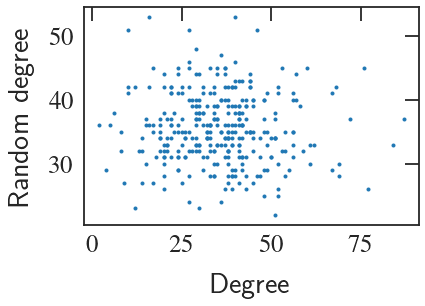

In [77]:
degree = G.degree()
degree_random = G_random.degree()
plt.plot(degree, degree_random, '.')
plt.xlabel('Degree')
plt.ylabel('Random degree')

As you can see, there is almost no correspondence between the degree and the random degree. This is not surprising, since all are treated the same in the random graph, while empirically there are clear differences (some people are more popular, some are more solitary). Indeed, this difference als becomes kleer if we look at the distribution of the degree.

The degree of each node is Poisson distributed (close to a normal distribution). On average each node has a degree of $\langle k \rangle = p n$ and most nodes have a degree relatively close to that.

Text(0, 0.5, 'Probability')

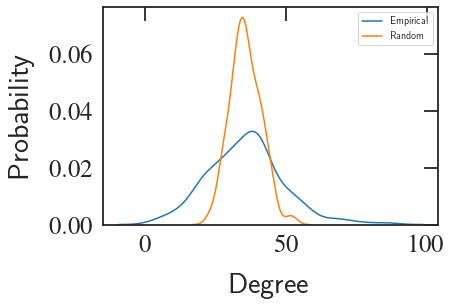

In [78]:
sns.kdeplot(np.array(degree), label='Empirical')
sns.kdeplot(np.array(degree_random), label='Random')
plt.legend(loc='best')
plt.xlabel('Degree')
plt.ylabel('Probability')

The empirical network has a much broader degree distribution than what is observed randomly. This is typically the case and most real-world networks have rather broad degree distribution. Since this happens so frequently, a common alternative type of random graph is often considered.

### Configuration model

The configuration models start from the observed empirical degrees. Rather than assuming that links have the same probability for all pairs of nodes, it is assumed that a node should have the same number of neighbours as observed empirically.

In [79]:
G_random_config = ig.Graph.Degree_Sequence(degree)

This creates a random graph having exactly the same degree for each node.

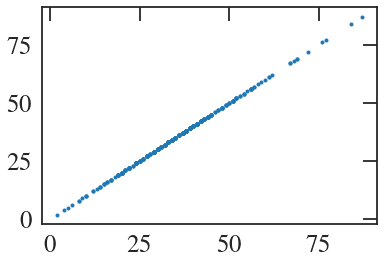

In [80]:
plt.plot(degree, G_random_config.degree(), '.')

Let us compare again the shortest path and the clustering coefficient.

In [81]:
avg_distance_random_config = np.array(G_random_config.shortest_paths()).mean()
print('Empirical average distance: {0:.2f}, random: {1:.2f}, configuration: {2:.2f}'.format(
        avg_distance, avg_distance_random, avg_distance_random_config))

clustering_random_config = G_random_config.transitivity_avglocal_undirected();
print('Empirical clustering: {0:.2f}, random: {1:.2f}, configuration: {2:.2f}'.format(
        clustering, clustering_random, clustering_random_config))

Empirical average distance: 2.15, random: 1.90, configuration: 1.96
Empirical clustering: 0.50, random: 0.11, configuration: 0.13


As you can see, the clustering and the average distance seems to be not so much affected by the changed degree distribution. Hence, the clustering is still significantly higher in the empirical network than randomly expected, while the average distance is more similar to the random graph. This is what is sometimes called a *small world*: a network with relatively high clustering and small distances.

One difficulty with graphs is that they sometimes show dependencies which you might not have expected at first sight. For example, it was thought that a decreasing clustering with higher degrees would be indicative of some hierarchical structure: the high degree nodes would connect people from different communities (low clustering), whereas the low degree nodes would connect mostly to people within the same community (high clustering). Let us check whether that is the case for our empirical network.

(-0.5759930806803097, 2.7120012913712467e-30)

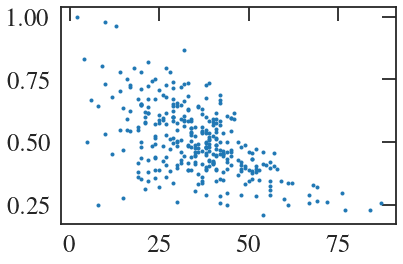

In [82]:
G.vs['clustering'] = G.transitivity_local_undirected()
plt.plot(G.degree(), G.vs['clustering'], '.')
scipy.stats.pearsonr(G.degree(), G.vs['clustering'])

The result above indicates there is quite a strong correlation between the clustering and the degree. The result is apparently also highly significant, as indicated by the p-value in the order of $10^{-30}$. However, this is misleading. The tests for significance in correlations assumes that the two variables both are independently sampled from some distribution, whereas this is not the case for networks. In fact, if we calculate the correlation for the random configuration graph, we see also a clear correlation:

(-0.18997580711495907, 0.0005529347487825389)

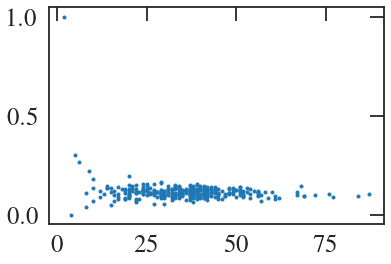

In [83]:
G_random_config.vs['clustering'] = G_random_config.transitivity_local_undirected()
plt.plot(G_random_config.degree(), G_random_config.vs['clustering'], '.')
scipy.stats.pearsonr(G_random_config.degree(), G_random_config.vs['clustering'])

Although the two plots are very distinct, the correlation between the degree and clustering is still 'significant' according to the p-value in the order of $10^{-5}$. The correlation is not as clear as in the empirical network, so there may be some merit to the idea of an hierarchical structure in the empirical network.

If you really want to establish that some observation is different from what can be expected at random, you should repeatedly perform the same analysis on a random graph, and compare your empirical results to the obtained distribution of results on a random graph.

The key point here is: don't trust p-values without reflecting on what they do exactly. Furthermore, not all non-zero results are necessarily significant: as we have just seen, a correlation of -0.23 can also be achieved in a random graph.

### Scale-free

Most networks seem to have a rather skewed degree distribution, which are sometimes referred to as scale-free networks. Already early in the 20<sup>th</sup> century it was suggested that such a type of distribution could arise via a rich-get-richer mechanism. Such a mechanism has also been called the Matthew effect or preferential attachment. The idea is always similar: the probability of getting one more link is proportional to the number of links a node already has. Indeed, such mechanisms do seem to operate (at least to some extent) in a number of networks. The most recent well-known model was introduced by Barabási & Albert, and is often simply referred to as the BA-model.

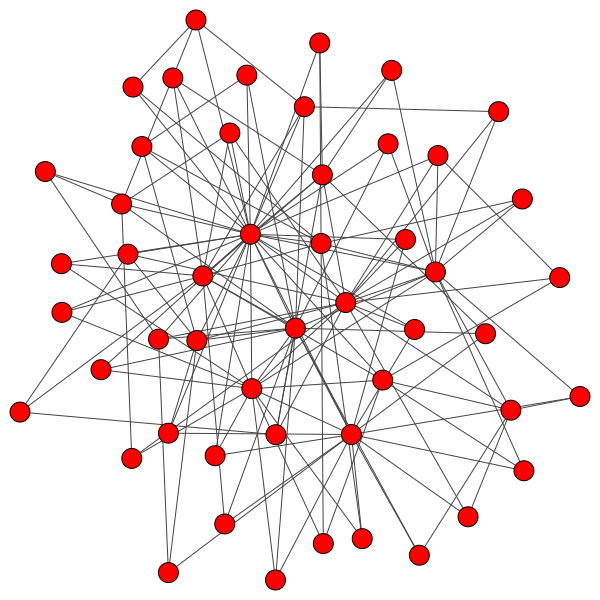

In [84]:
ig.plot(ig.Graph.Barabasi(n=50, m=3))

In practice, when comparing properties such as clustering or path length, it makes more sense to use the configuration model. Nonetheless, the scale-free model is often used to compare some process against the Erdös-Rényi graphs. For example, a spreading process works quite differently in scale-free graphs than in ER graphs.

## Spreading

Spreading processes are much like opinion processes, but they work slightly differently. Compared to the opinion dynamics examined earlier in this notebook, it usually only requires a single exposure to an "infected" individual to spread the infection. This is different from an opinion model, where it is usually assumed that only multiple exposures induce behavioral changes. This is sometimes referred to as the difference between *simple contagion* and *complex contagion*.

Let us examine a very simply process where some initial person becoming infected. After becoming infected, a person has a single chance to infect each of its neighbors. If some neighbor becomes infected the process continues from that neighbor.

In [85]:
def spreading(G, initial_node, p):
    G.vs['infected'] = False
    infect_nodes = [initial_node]
    while infect_nodes:
        v = infect_nodes.pop()
        v['infected'] = True
        for u in G.vs[G.neighbors(v)]:
            if not u['infected'] and np.random.rand() < p:
                infect_nodes.append(u)
    return sum(G.vs['infected'])

Let us try to see what happens if we start from some random node. Here below the probability is chosen such that on average about 1 neighbor is infected. As you will see, sometimes it will then spread quite some extent, whereas at other times it will not spread at all. You can try to run it multiple times to see how it changes.

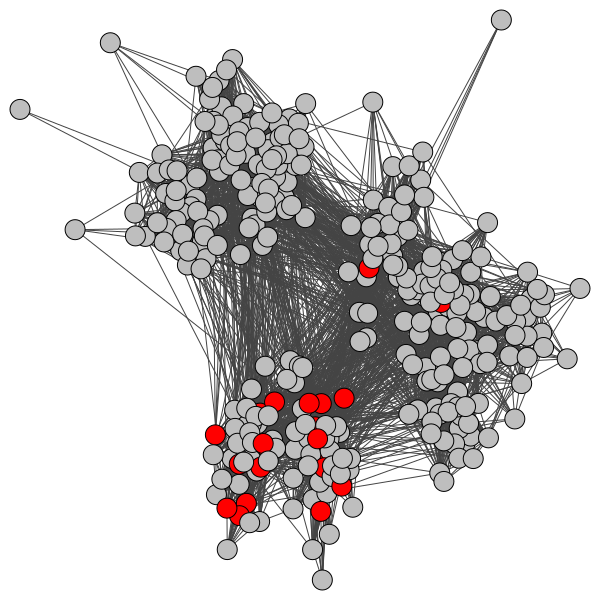

In [86]:
spreading(G, G.vs[np.random.randint(G.vcount())], 1/np.mean(G.degree()))
G.vs['color'] = ['red' if v['infected'] else 'gray' for v in G.vs]
ig.plot(G)

Let us look a bit more systematic into the spreading behavior by repeating it many times.

In [87]:
def repeat_spreading(G, p, n_runs):
    return np.mean([spreading(G, G.vs[np.random.randint(G.vcount())], p) for idx in range(n_runs)])

Now we can easily repeat it for different infection probabilities. It is interesting to see how it compares to the other two random graphs we previously encountered: the ER random graph and the configuration model.

<div class="alert alert-warning">
The following code may take quite some time to execute
</div>

In [88]:
n_runs = 10
p_list = np.linspace(0, 0.1, 10)
nb_infected = [repeat_spreading(G, p, n_runs) for p in p_list]
nb_infected_random = [repeat_spreading(G_random, p, n_runs) for p in p_list]
nb_infected_random_config = [repeat_spreading(G_random_config, p, n_runs) for p in p_list]
G_scale_free = ig.Graph.Barabasi(n=G.vcount(), m=int(np.mean(G.degree())))
nb_infected_scale_free = [repeat_spreading(G_scale_free, p, n_runs) for p in p_list]

Let us plot the results

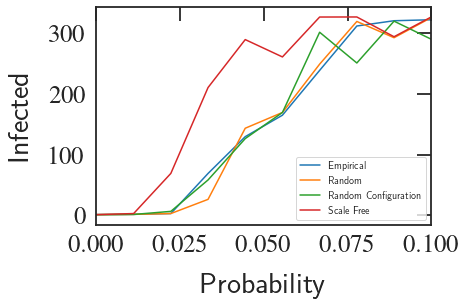

In [89]:
plt.plot(p_list, nb_infected, label='Empirical')
plt.plot(p_list, nb_infected_random, label='Random')
plt.plot(p_list, nb_infected_random_config, label='Random Configuration')
plt.plot(p_list, nb_infected_scale_free, label='Scale Free')
plt.xlim(0, 0.1)
plt.xlabel('Probability')
plt.ylabel('Infected')
plt.legend(loc='best')

The most clearest difference is that the scale-free network is much more "infectious", just because of its structure. This is a well-known result: ordinary random graphs have some threshold (here around 0.03) below which almost nobody is infected, and above which a sizeable part of the network becomes infected. In the scale-free graph this is radically different, and even for the smallest probabilities, infections always spread to a sizeable part of the network. The difference around 0.03 is substantial: more than 200 infections in a scale free graph, while not even 50 infections in the other graphs.

Nonetheless, for the highschool social network, the random graph is a very reasonable approximation, and the configuration model is an even better approximation. This is important because for further analysis we could use the random approximation, which makes it significantly easier and simpler to get further insights.

Remarkably, the presence of a clear group structure in terms of classes does not seem to have any effect. The group structure is completely absent in the configuration model, yet they show almost identical results. This is quite different compared to the opinion dynamics, which depend clearly on the group structure.

There are many other questions that are of interest here: how does the spreading depend on which node is infected first? How is it best contained? How many nodes need to be vaccinated so that spreading is unlikely?  We won't go into these question here, but as you can imagine, they are of great importance.